In [1]:
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import random
%matplotlib inline
import pickle as pkl
from tqdm import tqdm_notebook
random.seed(134)

In [2]:
#change labels
def change_label(label):
    if label == 'neutral':
        return 0.0
    elif label == 'entailment':
        return 1.0
    elif label == 'contradiction':
        return 2.0
    
def split_file_token(file):
    file_ls = []
    y = []
    with open(file) as fd:
        rd = csv.reader(fd, delimiter="\t", quotechar=' ')
        for row in rd:
            if row[0] == 'sentence1':
                pass
            else:
                file_ls.append([row[0].split(),row[1].split()])
                y.append(change_label(row[2]))
    return file_ls,y

In [3]:
snli_train_path = "hw2_data/snli_train.tsv"      
snli_train_token,snli_train_y = split_file_token(snli_train_path)
snli_val_path = "hw2_data/snli_val.tsv"
snli_val_token,snli_val_y = split_file_token(snli_val_path)

In [4]:
def tokenizer_dt(tokenizer_pair):
    premise = []
    hypothesis = []
    for i in tokenizer_pair:
        premise.append(i[0])
        hypothesis.append(i[1])
    return premise,hypothesis

#build vocabulary dictionary
PAD_IDX = 0
UNK_IDX = 1
Emb_Mtx = []
snli_train_token2id = {}
snli_train_id2token = {}

        
words_to_load = 60000    
with open('wiki-news-300d-1M.vec') as f:
    Emb_Mtx = np.zeros((words_to_load+2, 300))
    Emb_Mtx[UNK_IDX] = np.ones(300)
    snli_train_token2id['<pad>'] = PAD_IDX 
    snli_train_token2id['<unk>'] = UNK_IDX
    snli_train_id2token[PAD_IDX] = '<pad>'
    snli_train_id2token[UNK_IDX] = '<unk>'
    for i, line in tqdm_notebook(enumerate(f)):
        if i >= words_to_load: 
            break
        s = line.split()
        Emb_Mtx[i+2, :] = np.asarray(s[1:])
        snli_train_token2id[s[0]] = i+2
        snli_train_id2token[i+2] = s[0]

#get index
def token2index(tokens_data,token_id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token_id[token] if token in token_id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


In [5]:
train_premise,train_hypothesis = tokenizer_dt(snli_train_token)
val_premise,val_hypothesis = tokenizer_dt(snli_val_token)
Emb_Mtx = torch.from_numpy(Emb_Mtx)

In [6]:
indices_snli_train_pre = token2index(train_premise,snli_train_token2id)
indices_snli_train_hyp = token2index(train_hypothesis,snli_train_token2id)
indices_snli_val_pre = token2index(val_premise,snli_train_token2id)
indices_snli_val_hyp = token2index(val_hypothesis,snli_train_token2id)

In [7]:
#indices_snli_train_pre[11],indices_snli_train_hyp[187],indices_snli_val_pre[27],indices_snli_val_hyp[63]

([1443, 803, 2294, 35, 1664, 92, 4, 741, 2421, 17, 67, 499, 5],
 [1443, 272, 35, 26916, 38108, 5],
 [107,
  8724,
  5476,
  91,
  10,
  13573,
  49,
  10,
  3039,
  12579,
  2975,
  9,
  10,
  7922,
  20,
  10,
  13612,
  19519,
  5],
 [418,
  35,
  108,
  356,
  13432,
  9,
  1589,
  7,
  10,
  6243,
  2134,
  14,
  33,
  85,
  139,
  4161,
  702,
  5])

In [8]:
MAX_SENTENCE_LENGTH = 30
class SNLIDataset(Dataset):
    def __init__(self, data_list1, data_list2, target_list):
        
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))

    def __len__(self):
        #return len(self.data_list1)
        return len(self.target_list)
        
    def __getitem__(self, key):
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1),token_idx2, len(token_idx2), label]
    
def SNLI_collate_func(batch):
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[1])
        length_list2.append(datum[3])
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
        padded_vec2 = np.pad(np.array(datum[2]), 
                             pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                             mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    return [torch.from_numpy(np.array(data_list1)), torch.LongTensor(length_list1), 
            torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list2), 
            torch.LongTensor(label_list)]
    

In [9]:
# Build train, valid dataloaders
BATCH_SIZE = 32
train_dataset = SNLIDataset(indices_snli_train_pre,indices_snli_train_hyp, snli_train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(indices_snli_val_pre,indices_snli_val_hyp, snli_val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [10]:
class RNN(nn.Module):
    def __init__(self, hidden_size1, hidden_size2,size, num_layers, num_classes, emb_size=300):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        
        super(RNN, self).__init__()

        self.num_layers, self.size = num_layers, size
        self.hidden_size1,self.hidden_size2 = hidden_size1, hidden_size2
        
        self.embedding = nn.Embedding.from_pretrained(Emb_Mtx).float()
       
        self.rnn1 = nn.GRU(emb_size, hidden_size1, num_layers, batch_first = True, bidirectional = True)
        self.rnn2 = nn.GRU(emb_size, hidden_size2, num_layers, batch_first = True, bidirectional = True)  
        
        self.linear1 = nn.Linear(hidden_size1 + hidden_size2, size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(size, num_classes)

    def init_hidden(self, batch_size, hidden_size):
        hidden = torch.randn(self.num_layers * 2 , batch_size, hidden_size)
        return hidden

    def forward(self, x1, lengths1, x2, lengths2):
        
        # reset hidden state
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        
        self.hidden1 = self.init_hidden(batch_size1,self.hidden_size1)
        self.hidden2 = self.init_hidden(batch_size2,self.hidden_size2)

        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
 
        # no pack padded sequence
    
        # fprop though RNN
        rnn_out1, self.hidden1 = self.rnn1(embed1, self.hidden1)
        rnn_out2, self.hidden2 = self.rnn2(embed2, self.hidden2)
        
       
        # sum hidden activations of RNN across time
        cat_out = torch.cat([self.hidden1,self.hidden2],dim = -1) 
        rnn_out = torch.sum(cat_out, dim=0)
        rnn_out = self.linear1(rnn_out)
        rnn_out = self.relu(rnn_out)
        logits = self.linear2(rnn_out)
        
        return logits


In [11]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, lengths1, data2, lengths2, labels in loader:
        data_batch1, lengths_batch1, label_batch = data1, lengths1, labels
        data_batch2, lengths_batch2 = data2, lengths2
        outputs = F.softmax(model(data_batch1, lengths_batch1,data_batch2, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [12]:
def plot_model(train_ls,train_acc,val_acc):
    plt.subplot(2, 1, 1)
    plt.plot(train_ls)
    plt.xlabel("i")
    plt.ylabel("Train Loss")
    
    plt.subplot(2, 1, 2)
    plt.plot(train_acc,label='Train Acc')
    plt.plot(val_acc,label='Val Acc')
    #plt.xlabel("i%1000")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [13]:
def train_model_RNN(model,learning_rate,num_epochs):
    #report model parameter
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of parameters in the model is :{}".format(params))
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # Train the model
    total_step = len(train_loader)
    
    train_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        for i, (data1, lengths1, data2, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, lengths1, data2, lengths2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc.append(test_model(train_loader, model))
                val_acc.append(test_model(val_loader, model))
                print('Epoch: [{}/{}], Step: [{}/{}], Train Acc: {},Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), train_acc[-1],val_acc[-1]))
    #val_acc_last = test_model(val_loader, model)
    #print("Val Accuracy:{}".format(val_acc_last))
    return train_loss,train_acc,val_acc
    #return train_loss,pd.DataFrame([train_acc,val_acc], columns=['train_acc','val_acc'])
    #plot_model(train_ls,train_acc,val_acc)

In [14]:
model = RNN(hidden_size1 = 50, hidden_size2 = 50,size = 50, num_layers = 1, num_classes = 3)
train_loss1,train_acc1,val_acc1= train_model_RNN(model,3e-4,1)

Number of parameters in the model is :216403
Epoch: [1/1], Step: [101/3125], Train Acc: 37.657,Validation Acc: 40.7
Epoch: [1/1], Step: [201/3125], Train Acc: 38.601,Validation Acc: 39.8
Epoch: [1/1], Step: [301/3125], Train Acc: 42.175,Validation Acc: 40.6
Epoch: [1/1], Step: [401/3125], Train Acc: 47.094,Validation Acc: 45.4
Epoch: [1/1], Step: [501/3125], Train Acc: 46.491,Validation Acc: 45.6
Epoch: [1/1], Step: [601/3125], Train Acc: 49.464,Validation Acc: 49.4
Epoch: [1/1], Step: [701/3125], Train Acc: 49.393,Validation Acc: 49.7
Epoch: [1/1], Step: [801/3125], Train Acc: 52.114,Validation Acc: 53.1
Epoch: [1/1], Step: [901/3125], Train Acc: 54.259,Validation Acc: 55.0
Epoch: [1/1], Step: [1001/3125], Train Acc: 55.719,Validation Acc: 55.6
Epoch: [1/1], Step: [1101/3125], Train Acc: 55.036,Validation Acc: 55.6
Epoch: [1/1], Step: [1201/3125], Train Acc: 56.521,Validation Acc: 57.3
Epoch: [1/1], Step: [1301/3125], Train Acc: 55.862,Validation Acc: 55.2
Epoch: [1/1], Step: [1401/31

In [42]:
print(val_acc1[-1])

59.3


In [15]:
model = RNN(hidden_size1 = 50, hidden_size2 = 50,size = 50, num_layers = 1, num_classes = 3)
train_loss2,train_acc2,val_acc2= train_model_RNN(model,3e-4,5)

Number of parameters in the model is :216403
Epoch: [1/5], Step: [101/3125], Train Acc: 38.258,Validation Acc: 40.4
Epoch: [1/5], Step: [201/3125], Train Acc: 39.652,Validation Acc: 40.7
Epoch: [1/5], Step: [301/3125], Train Acc: 43.047,Validation Acc: 42.4
Epoch: [1/5], Step: [401/3125], Train Acc: 45.957,Validation Acc: 44.7
Epoch: [1/5], Step: [501/3125], Train Acc: 47.274,Validation Acc: 45.5
Epoch: [1/5], Step: [601/3125], Train Acc: 46.991,Validation Acc: 45.4
Epoch: [1/5], Step: [701/3125], Train Acc: 50.276,Validation Acc: 50.3
Epoch: [1/5], Step: [801/3125], Train Acc: 50.742,Validation Acc: 50.0
Epoch: [1/5], Step: [901/3125], Train Acc: 51.313,Validation Acc: 51.5
Epoch: [1/5], Step: [1001/3125], Train Acc: 52.404,Validation Acc: 51.7
Epoch: [1/5], Step: [1101/3125], Train Acc: 54.12,Validation Acc: 55.2
Epoch: [1/5], Step: [1201/3125], Train Acc: 55.283,Validation Acc: 53.2
Epoch: [1/5], Step: [1301/3125], Train Acc: 55.717,Validation Acc: 54.1
Epoch: [1/5], Step: [1401/312

Epoch: [4/5], Step: [2201/3125], Train Acc: 63.986,Validation Acc: 62.8
Epoch: [4/5], Step: [2301/3125], Train Acc: 64.311,Validation Acc: 63.4
Epoch: [4/5], Step: [2401/3125], Train Acc: 64.298,Validation Acc: 63.4
Epoch: [4/5], Step: [2501/3125], Train Acc: 64.495,Validation Acc: 63.8
Epoch: [4/5], Step: [2601/3125], Train Acc: 64.363,Validation Acc: 64.2
Epoch: [4/5], Step: [2701/3125], Train Acc: 63.594,Validation Acc: 62.6
Epoch: [4/5], Step: [2801/3125], Train Acc: 64.644,Validation Acc: 63.7
Epoch: [4/5], Step: [2901/3125], Train Acc: 64.437,Validation Acc: 63.0
Epoch: [4/5], Step: [3001/3125], Train Acc: 64.309,Validation Acc: 62.5
Epoch: [4/5], Step: [3101/3125], Train Acc: 64.575,Validation Acc: 63.1
Epoch: [5/5], Step: [101/3125], Train Acc: 64.399,Validation Acc: 63.0
Epoch: [5/5], Step: [201/3125], Train Acc: 64.513,Validation Acc: 63.7
Epoch: [5/5], Step: [301/3125], Train Acc: 64.454,Validation Acc: 63.2
Epoch: [5/5], Step: [401/3125], Train Acc: 64.919,Validation Acc: 6

In [43]:
print(val_acc2[-1])

64.0


In [16]:
model = RNN(hidden_size1 = 150, hidden_size2 = 150,size = 50, num_layers = 1, num_classes = 3)
train_loss3,train_acc3,val_acc3= train_model_RNN(model,3e-4,10)

Number of parameters in the model is :828803
Epoch: [1/10], Step: [101/3125], Train Acc: 37.87,Validation Acc: 37.4
Epoch: [1/10], Step: [201/3125], Train Acc: 44.4,Validation Acc: 41.9
Epoch: [1/10], Step: [301/3125], Train Acc: 46.872,Validation Acc: 46.8
Epoch: [1/10], Step: [401/3125], Train Acc: 49.002,Validation Acc: 49.5
Epoch: [1/10], Step: [501/3125], Train Acc: 50.234,Validation Acc: 51.2
Epoch: [1/10], Step: [601/3125], Train Acc: 52.399,Validation Acc: 52.7
Epoch: [1/10], Step: [701/3125], Train Acc: 54.352,Validation Acc: 53.9
Epoch: [1/10], Step: [801/3125], Train Acc: 54.436,Validation Acc: 54.2
Epoch: [1/10], Step: [901/3125], Train Acc: 55.879,Validation Acc: 55.1
Epoch: [1/10], Step: [1001/3125], Train Acc: 56.903,Validation Acc: 56.3
Epoch: [1/10], Step: [1101/3125], Train Acc: 57.251,Validation Acc: 57.2
Epoch: [1/10], Step: [1201/3125], Train Acc: 56.502,Validation Acc: 55.5
Epoch: [1/10], Step: [1301/3125], Train Acc: 55.762,Validation Acc: 55.0
Epoch: [1/10], Ste

Epoch: [4/10], Step: [2101/3125], Train Acc: 67.101,Validation Acc: 67.7
Epoch: [4/10], Step: [2201/3125], Train Acc: 67.02,Validation Acc: 67.2
Epoch: [4/10], Step: [2301/3125], Train Acc: 65.871,Validation Acc: 65.7
Epoch: [4/10], Step: [2401/3125], Train Acc: 67.811,Validation Acc: 65.9
Epoch: [4/10], Step: [2501/3125], Train Acc: 67.724,Validation Acc: 67.2
Epoch: [4/10], Step: [2601/3125], Train Acc: 66.974,Validation Acc: 67.1
Epoch: [4/10], Step: [2701/3125], Train Acc: 67.403,Validation Acc: 66.5
Epoch: [4/10], Step: [2801/3125], Train Acc: 67.944,Validation Acc: 66.5
Epoch: [4/10], Step: [2901/3125], Train Acc: 67.493,Validation Acc: 67.1
Epoch: [4/10], Step: [3001/3125], Train Acc: 67.85,Validation Acc: 64.8
Epoch: [4/10], Step: [3101/3125], Train Acc: 67.434,Validation Acc: 66.8
Epoch: [5/10], Step: [101/3125], Train Acc: 67.649,Validation Acc: 67.5
Epoch: [5/10], Step: [201/3125], Train Acc: 66.982,Validation Acc: 67.0
Epoch: [5/10], Step: [301/3125], Train Acc: 68.237,Vali

Epoch: [8/10], Step: [1001/3125], Train Acc: 72.378,Validation Acc: 68.4
Epoch: [8/10], Step: [1101/3125], Train Acc: 72.167,Validation Acc: 68.3
Epoch: [8/10], Step: [1201/3125], Train Acc: 71.962,Validation Acc: 67.6
Epoch: [8/10], Step: [1301/3125], Train Acc: 71.61,Validation Acc: 66.9
Epoch: [8/10], Step: [1401/3125], Train Acc: 71.638,Validation Acc: 68.3
Epoch: [8/10], Step: [1501/3125], Train Acc: 71.299,Validation Acc: 67.6
Epoch: [8/10], Step: [1601/3125], Train Acc: 72.372,Validation Acc: 69.0
Epoch: [8/10], Step: [1701/3125], Train Acc: 70.683,Validation Acc: 66.8
Epoch: [8/10], Step: [1801/3125], Train Acc: 71.662,Validation Acc: 67.7
Epoch: [8/10], Step: [1901/3125], Train Acc: 72.486,Validation Acc: 69.1
Epoch: [8/10], Step: [2001/3125], Train Acc: 72.291,Validation Acc: 68.7
Epoch: [8/10], Step: [2101/3125], Train Acc: 72.262,Validation Acc: 68.2
Epoch: [8/10], Step: [2201/3125], Train Acc: 72.726,Validation Acc: 68.2
Epoch: [8/10], Step: [2301/3125], Train Acc: 72.412,

In [44]:
print(val_acc3[-1])

68.8


In [54]:
model = RNN(hidden_size1 = 150, hidden_size2 = 150,size = 50, num_layers = 1, num_classes = 3)
train_loss31,train_acc31,val_acc31= train_model_RNN(model,3e-4,5)

Number of parameters in the model is :828803
Epoch: [1/5], Step: [101/3125], Train Acc: 37.671,Validation Acc: 36.9
Epoch: [1/5], Step: [201/3125], Train Acc: 45.204,Validation Acc: 43.8
Epoch: [1/5], Step: [301/3125], Train Acc: 47.739,Validation Acc: 46.8
Epoch: [1/5], Step: [401/3125], Train Acc: 49.42,Validation Acc: 48.5
Epoch: [1/5], Step: [501/3125], Train Acc: 50.173,Validation Acc: 50.6
Epoch: [1/5], Step: [601/3125], Train Acc: 52.521,Validation Acc: 54.3
Epoch: [1/5], Step: [701/3125], Train Acc: 54.945,Validation Acc: 56.1
Epoch: [1/5], Step: [801/3125], Train Acc: 55.664,Validation Acc: 56.4
Epoch: [1/5], Step: [901/3125], Train Acc: 56.152,Validation Acc: 55.7
Epoch: [1/5], Step: [1001/3125], Train Acc: 55.662,Validation Acc: 56.6
Epoch: [1/5], Step: [1101/3125], Train Acc: 56.346,Validation Acc: 53.7
Epoch: [1/5], Step: [1201/3125], Train Acc: 57.905,Validation Acc: 58.1
Epoch: [1/5], Step: [1301/3125], Train Acc: 57.791,Validation Acc: 58.0
Epoch: [1/5], Step: [1401/312

Epoch: [4/5], Step: [2201/3125], Train Acc: 66.841,Validation Acc: 65.9
Epoch: [4/5], Step: [2301/3125], Train Acc: 67.0,Validation Acc: 65.7
Epoch: [4/5], Step: [2401/3125], Train Acc: 67.214,Validation Acc: 66.2
Epoch: [4/5], Step: [2501/3125], Train Acc: 66.556,Validation Acc: 65.3
Epoch: [4/5], Step: [2601/3125], Train Acc: 66.864,Validation Acc: 66.5
Epoch: [4/5], Step: [2701/3125], Train Acc: 66.705,Validation Acc: 65.8
Epoch: [4/5], Step: [2801/3125], Train Acc: 67.516,Validation Acc: 66.8
Epoch: [4/5], Step: [2901/3125], Train Acc: 67.148,Validation Acc: 65.9
Epoch: [4/5], Step: [3001/3125], Train Acc: 67.362,Validation Acc: 65.8
Epoch: [4/5], Step: [3101/3125], Train Acc: 67.858,Validation Acc: 66.0
Epoch: [5/5], Step: [101/3125], Train Acc: 67.862,Validation Acc: 66.4
Epoch: [5/5], Step: [201/3125], Train Acc: 67.572,Validation Acc: 65.8
Epoch: [5/5], Step: [301/3125], Train Acc: 67.65,Validation Acc: 66.1
Epoch: [5/5], Step: [401/3125], Train Acc: 68.219,Validation Acc: 68.4

In [57]:
print(val_acc31[-1])

68.2


In [20]:
model = RNN(hidden_size1 = 150, hidden_size2 = 150,size = 150, num_layers = 1, num_classes = 3)
train_loss4,train_acc4,val_acc4= train_model_RNN(model,3e-5,5)

Number of parameters in the model is :859203
Epoch: [1/5], Step: [101/3125], Train Acc: 33.311,Validation Acc: 34.2
Epoch: [1/5], Step: [201/3125], Train Acc: 34.989,Validation Acc: 34.2
Epoch: [1/5], Step: [301/3125], Train Acc: 34.845,Validation Acc: 34.4
Epoch: [1/5], Step: [401/3125], Train Acc: 38.724,Validation Acc: 40.1
Epoch: [1/5], Step: [501/3125], Train Acc: 38.551,Validation Acc: 38.1
Epoch: [1/5], Step: [601/3125], Train Acc: 39.323,Validation Acc: 38.5
Epoch: [1/5], Step: [701/3125], Train Acc: 39.34,Validation Acc: 38.9
Epoch: [1/5], Step: [801/3125], Train Acc: 37.788,Validation Acc: 37.6
Epoch: [1/5], Step: [901/3125], Train Acc: 40.725,Validation Acc: 39.4
Epoch: [1/5], Step: [1001/3125], Train Acc: 43.383,Validation Acc: 41.7
Epoch: [1/5], Step: [1101/3125], Train Acc: 43.146,Validation Acc: 42.4
Epoch: [1/5], Step: [1201/3125], Train Acc: 45.371,Validation Acc: 44.0
Epoch: [1/5], Step: [1301/3125], Train Acc: 45.277,Validation Acc: 43.6
Epoch: [1/5], Step: [1401/312

Epoch: [4/5], Step: [2201/3125], Train Acc: 58.647,Validation Acc: 56.0
Epoch: [4/5], Step: [2301/3125], Train Acc: 59.042,Validation Acc: 57.3
Epoch: [4/5], Step: [2401/3125], Train Acc: 58.552,Validation Acc: 58.5
Epoch: [4/5], Step: [2501/3125], Train Acc: 59.135,Validation Acc: 57.8
Epoch: [4/5], Step: [2601/3125], Train Acc: 59.003,Validation Acc: 57.4
Epoch: [4/5], Step: [2701/3125], Train Acc: 58.776,Validation Acc: 57.5
Epoch: [4/5], Step: [2801/3125], Train Acc: 58.618,Validation Acc: 57.8
Epoch: [4/5], Step: [2901/3125], Train Acc: 59.108,Validation Acc: 57.0
Epoch: [4/5], Step: [3001/3125], Train Acc: 59.057,Validation Acc: 57.6
Epoch: [4/5], Step: [3101/3125], Train Acc: 59.025,Validation Acc: 58.4
Epoch: [5/5], Step: [101/3125], Train Acc: 59.228,Validation Acc: 57.3
Epoch: [5/5], Step: [201/3125], Train Acc: 59.157,Validation Acc: 57.9
Epoch: [5/5], Step: [301/3125], Train Acc: 59.138,Validation Acc: 57.8
Epoch: [5/5], Step: [401/3125], Train Acc: 58.942,Validation Acc: 5

In [45]:
print(val_acc4[-1])

58.5


In [21]:
model = RNN(hidden_size1 = 200, hidden_size2 = 100,size = 50, num_layers = 1, num_classes = 3)
train_loss5,train_acc5,val_acc5 = train_model_RNN(model,3e-4,5)

Number of parameters in the model is :858803
Epoch: [1/5], Step: [101/3125], Train Acc: 38.947,Validation Acc: 36.3
Epoch: [1/5], Step: [201/3125], Train Acc: 43.559,Validation Acc: 40.5
Epoch: [1/5], Step: [301/3125], Train Acc: 45.092,Validation Acc: 43.9
Epoch: [1/5], Step: [401/3125], Train Acc: 48.31,Validation Acc: 46.3
Epoch: [1/5], Step: [501/3125], Train Acc: 48.431,Validation Acc: 46.8
Epoch: [1/5], Step: [601/3125], Train Acc: 49.557,Validation Acc: 47.7
Epoch: [1/5], Step: [701/3125], Train Acc: 50.627,Validation Acc: 48.4
Epoch: [1/5], Step: [801/3125], Train Acc: 50.191,Validation Acc: 50.6
Epoch: [1/5], Step: [901/3125], Train Acc: 51.532,Validation Acc: 49.7
Epoch: [1/5], Step: [1001/3125], Train Acc: 52.119,Validation Acc: 50.4
Epoch: [1/5], Step: [1101/3125], Train Acc: 52.468,Validation Acc: 51.0
Epoch: [1/5], Step: [1201/3125], Train Acc: 52.93,Validation Acc: 52.6
Epoch: [1/5], Step: [1301/3125], Train Acc: 55.937,Validation Acc: 55.4
Epoch: [1/5], Step: [1401/3125

Epoch: [4/5], Step: [2201/3125], Train Acc: 65.76,Validation Acc: 65.1
Epoch: [4/5], Step: [2301/3125], Train Acc: 65.885,Validation Acc: 64.7
Epoch: [4/5], Step: [2401/3125], Train Acc: 65.907,Validation Acc: 64.4
Epoch: [4/5], Step: [2501/3125], Train Acc: 66.27,Validation Acc: 64.9
Epoch: [4/5], Step: [2601/3125], Train Acc: 65.775,Validation Acc: 64.3
Epoch: [4/5], Step: [2701/3125], Train Acc: 65.891,Validation Acc: 65.2
Epoch: [4/5], Step: [2801/3125], Train Acc: 66.575,Validation Acc: 65.8
Epoch: [4/5], Step: [2901/3125], Train Acc: 66.495,Validation Acc: 65.2
Epoch: [4/5], Step: [3001/3125], Train Acc: 66.672,Validation Acc: 64.9
Epoch: [4/5], Step: [3101/3125], Train Acc: 66.547,Validation Acc: 65.8
Epoch: [5/5], Step: [101/3125], Train Acc: 67.046,Validation Acc: 67.0
Epoch: [5/5], Step: [201/3125], Train Acc: 67.2,Validation Acc: 66.9
Epoch: [5/5], Step: [301/3125], Train Acc: 66.458,Validation Acc: 66.3
Epoch: [5/5], Step: [401/3125], Train Acc: 66.719,Validation Acc: 64.9


In [46]:
print(val_acc5[-1])

66.8


In [24]:
model = RNN(hidden_size1 = 100, hidden_size2 = 100,size = 50, num_layers = 1, num_classes = 3)
train_loss6,train_acc6,val_acc6= train_model_RNN(model,3e-4,10)

Number of parameters in the model is :492603
Epoch: [1/10], Step: [101/3125], Train Acc: 34.482,Validation Acc: 33.0
Epoch: [1/10], Step: [201/3125], Train Acc: 43.2,Validation Acc: 39.8
Epoch: [1/10], Step: [301/3125], Train Acc: 46.008,Validation Acc: 43.4
Epoch: [1/10], Step: [401/3125], Train Acc: 48.742,Validation Acc: 48.0
Epoch: [1/10], Step: [501/3125], Train Acc: 49.265,Validation Acc: 49.9
Epoch: [1/10], Step: [601/3125], Train Acc: 50.716,Validation Acc: 51.3
Epoch: [1/10], Step: [701/3125], Train Acc: 51.902,Validation Acc: 51.0
Epoch: [1/10], Step: [801/3125], Train Acc: 54.48,Validation Acc: 55.2
Epoch: [1/10], Step: [901/3125], Train Acc: 54.896,Validation Acc: 54.9
Epoch: [1/10], Step: [1001/3125], Train Acc: 54.849,Validation Acc: 54.2
Epoch: [1/10], Step: [1101/3125], Train Acc: 55.876,Validation Acc: 54.5
Epoch: [1/10], Step: [1201/3125], Train Acc: 56.703,Validation Acc: 56.4
Epoch: [1/10], Step: [1301/3125], Train Acc: 57.499,Validation Acc: 56.0
Epoch: [1/10], Ste

Epoch: [4/10], Step: [2101/3125], Train Acc: 64.262,Validation Acc: 61.9
Epoch: [4/10], Step: [2201/3125], Train Acc: 65.688,Validation Acc: 64.1
Epoch: [4/10], Step: [2301/3125], Train Acc: 65.036,Validation Acc: 62.8
Epoch: [4/10], Step: [2401/3125], Train Acc: 65.463,Validation Acc: 63.6
Epoch: [4/10], Step: [2501/3125], Train Acc: 65.457,Validation Acc: 63.2
Epoch: [4/10], Step: [2601/3125], Train Acc: 65.176,Validation Acc: 62.3
Epoch: [4/10], Step: [2701/3125], Train Acc: 65.006,Validation Acc: 63.1
Epoch: [4/10], Step: [2801/3125], Train Acc: 66.168,Validation Acc: 65.0
Epoch: [4/10], Step: [2901/3125], Train Acc: 66.595,Validation Acc: 64.2
Epoch: [4/10], Step: [3001/3125], Train Acc: 64.975,Validation Acc: 63.6
Epoch: [4/10], Step: [3101/3125], Train Acc: 66.31,Validation Acc: 63.4
Epoch: [5/10], Step: [101/3125], Train Acc: 66.397,Validation Acc: 65.1
Epoch: [5/10], Step: [201/3125], Train Acc: 66.404,Validation Acc: 64.6
Epoch: [5/10], Step: [301/3125], Train Acc: 66.584,Val

Epoch: [8/10], Step: [1001/3125], Train Acc: 70.764,Validation Acc: 67.5
Epoch: [8/10], Step: [1101/3125], Train Acc: 70.79,Validation Acc: 66.4
Epoch: [8/10], Step: [1201/3125], Train Acc: 71.284,Validation Acc: 68.4
Epoch: [8/10], Step: [1301/3125], Train Acc: 70.858,Validation Acc: 66.8
Epoch: [8/10], Step: [1401/3125], Train Acc: 71.098,Validation Acc: 68.1
Epoch: [8/10], Step: [1501/3125], Train Acc: 70.961,Validation Acc: 68.5
Epoch: [8/10], Step: [1601/3125], Train Acc: 71.178,Validation Acc: 67.9
Epoch: [8/10], Step: [1701/3125], Train Acc: 71.254,Validation Acc: 68.3
Epoch: [8/10], Step: [1801/3125], Train Acc: 70.992,Validation Acc: 69.0
Epoch: [8/10], Step: [1901/3125], Train Acc: 71.364,Validation Acc: 67.6
Epoch: [8/10], Step: [2001/3125], Train Acc: 71.033,Validation Acc: 67.5
Epoch: [8/10], Step: [2101/3125], Train Acc: 69.148,Validation Acc: 64.5
Epoch: [8/10], Step: [2201/3125], Train Acc: 70.9,Validation Acc: 67.6
Epoch: [8/10], Step: [2301/3125], Train Acc: 71.471,Va

In [48]:
print(val_acc6[-1])

67.4


In [53]:
model = RNN(hidden_size1 = 100, hidden_size2 = 100,size = 50, num_layers = 1, num_classes = 3)
train_loss61,train_acc61,val_acc61= train_model_RNN(model,3e-4,5)

Number of parameters in the model is :492603
Epoch: [1/5], Step: [101/3125], Train Acc: 35.679,Validation Acc: 34.6
Epoch: [1/5], Step: [201/3125], Train Acc: 41.156,Validation Acc: 38.6
Epoch: [1/5], Step: [301/3125], Train Acc: 46.852,Validation Acc: 47.8
Epoch: [1/5], Step: [401/3125], Train Acc: 48.44,Validation Acc: 47.2
Epoch: [1/5], Step: [501/3125], Train Acc: 49.703,Validation Acc: 48.6
Epoch: [1/5], Step: [601/3125], Train Acc: 50.42,Validation Acc: 49.0
Epoch: [1/5], Step: [701/3125], Train Acc: 49.773,Validation Acc: 47.8
Epoch: [1/5], Step: [801/3125], Train Acc: 53.765,Validation Acc: 53.8
Epoch: [1/5], Step: [901/3125], Train Acc: 55.386,Validation Acc: 54.9
Epoch: [1/5], Step: [1001/3125], Train Acc: 55.538,Validation Acc: 55.9
Epoch: [1/5], Step: [1101/3125], Train Acc: 53.892,Validation Acc: 53.0
Epoch: [1/5], Step: [1201/3125], Train Acc: 56.623,Validation Acc: 55.9
Epoch: [1/5], Step: [1301/3125], Train Acc: 56.427,Validation Acc: 55.7
Epoch: [1/5], Step: [1401/3125

Epoch: [4/5], Step: [2201/3125], Train Acc: 65.191,Validation Acc: 64.3
Epoch: [4/5], Step: [2301/3125], Train Acc: 64.521,Validation Acc: 63.2
Epoch: [4/5], Step: [2401/3125], Train Acc: 64.592,Validation Acc: 63.0
Epoch: [4/5], Step: [2501/3125], Train Acc: 65.558,Validation Acc: 64.4
Epoch: [4/5], Step: [2601/3125], Train Acc: 65.353,Validation Acc: 62.8
Epoch: [4/5], Step: [2701/3125], Train Acc: 65.52,Validation Acc: 63.6
Epoch: [4/5], Step: [2801/3125], Train Acc: 65.4,Validation Acc: 63.5
Epoch: [4/5], Step: [2901/3125], Train Acc: 64.595,Validation Acc: 62.3
Epoch: [4/5], Step: [3001/3125], Train Acc: 64.942,Validation Acc: 64.1
Epoch: [4/5], Step: [3101/3125], Train Acc: 64.917,Validation Acc: 62.6
Epoch: [5/5], Step: [101/3125], Train Acc: 65.595,Validation Acc: 63.1
Epoch: [5/5], Step: [201/3125], Train Acc: 65.611,Validation Acc: 65.4
Epoch: [5/5], Step: [301/3125], Train Acc: 64.832,Validation Acc: 63.2
Epoch: [5/5], Step: [401/3125], Train Acc: 65.729,Validation Acc: 65.3

In [58]:
print(val_acc61[-1])

67.6


In [110]:
def test_model_print(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, lengths1, data2, lengths2, labels in loader:
        data_batch1, lengths_batch1, label_batch = data1, lengths1, labels
        data_batch2, lengths_batch2 = data2, lengths2
        outputs = F.softmax(model(data_batch1, lengths_batch1,data_batch2, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        print(predicted)

In [113]:
model_best= RNN(hidden_size1 = 150, hidden_size2 = 150,size = 50, num_layers = 1, num_classes = 3)
train_loss_best,train_acc_best,val_acc_best = train_model_RNN(model_best,3e-4,5)

Number of parameters in the model is :828803
Epoch: [1/5], Step: [101/3125], Train Acc: 36.84,Validation Acc: 36.0
Epoch: [1/5], Step: [201/3125], Train Acc: 44.492,Validation Acc: 40.6
Epoch: [1/5], Step: [301/3125], Train Acc: 46.287,Validation Acc: 44.9
Epoch: [1/5], Step: [401/3125], Train Acc: 50.206,Validation Acc: 49.9
Epoch: [1/5], Step: [501/3125], Train Acc: 51.906,Validation Acc: 51.2
Epoch: [1/5], Step: [601/3125], Train Acc: 54.554,Validation Acc: 54.9
Epoch: [1/5], Step: [701/3125], Train Acc: 55.889,Validation Acc: 55.1
Epoch: [1/5], Step: [801/3125], Train Acc: 55.949,Validation Acc: 56.0
Epoch: [1/5], Step: [901/3125], Train Acc: 55.615,Validation Acc: 53.4
Epoch: [1/5], Step: [1001/3125], Train Acc: 56.37,Validation Acc: 56.0
Epoch: [1/5], Step: [1101/3125], Train Acc: 56.461,Validation Acc: 56.1
Epoch: [1/5], Step: [1201/3125], Train Acc: 57.824,Validation Acc: 57.4
Epoch: [1/5], Step: [1301/3125], Train Acc: 57.765,Validation Acc: 56.5
Epoch: [1/5], Step: [1401/3125

Epoch: [4/5], Step: [2201/3125], Train Acc: 66.622,Validation Acc: 65.4
Epoch: [4/5], Step: [2301/3125], Train Acc: 67.124,Validation Acc: 66.6
Epoch: [4/5], Step: [2401/3125], Train Acc: 67.332,Validation Acc: 66.4
Epoch: [4/5], Step: [2501/3125], Train Acc: 67.223,Validation Acc: 66.1
Epoch: [4/5], Step: [2601/3125], Train Acc: 67.038,Validation Acc: 65.0
Epoch: [4/5], Step: [2701/3125], Train Acc: 67.063,Validation Acc: 65.8
Epoch: [4/5], Step: [2801/3125], Train Acc: 66.941,Validation Acc: 66.5
Epoch: [4/5], Step: [2901/3125], Train Acc: 67.273,Validation Acc: 67.5
Epoch: [4/5], Step: [3001/3125], Train Acc: 66.273,Validation Acc: 66.5
Epoch: [4/5], Step: [3101/3125], Train Acc: 67.397,Validation Acc: 67.5
Epoch: [5/5], Step: [101/3125], Train Acc: 67.456,Validation Acc: 67.0
Epoch: [5/5], Step: [201/3125], Train Acc: 68.024,Validation Acc: 67.1
Epoch: [5/5], Step: [301/3125], Train Acc: 67.111,Validation Acc: 65.6
Epoch: [5/5], Step: [401/3125], Train Acc: 68.122,Validation Acc: 6

In [114]:
test_model_print(val_loader,model_best)

tensor([[2],
        [0],
        [2],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [2],
        [0],
        [2],
        [2],
        [1],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [2],
        [0],
        [2],
        [2]])
tensor([[0],
        [0],
        [2],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [2],
        [0],
        [0],
        [2],
        [0],
        [2],
        [0],
        [1],
        [0],
        [2],
        [0],
        [1],
        [2],
        [1],
        [2],
        [1],
        [0]])
tensor([[0],
        [2],
        [1],
        [1],
        [1],
        [1],
        [2],
        [2],
        [0],
        [0],
        [0],
        [1],
        [0

tensor([[1],
        [2],
        [0],
        [0],
        [1],
        [0],
        [0],
        [2],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [2],
        [0],
        [2],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [2],
        [1],
        [0],
        [2],
        [2],
        [2],
        [2]])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [2],
        [1],
        [1],
        [1],
        [2],
        [2],
        [2],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [2],
        [2],
        [1],
        [0],
        [0],
        [2],
        [1],
        [1],
        [2],
        [2],
        [1],
        [2]])
tensor([[2],
        [0],
        [1],
        [2],
        [0],
        [1],
        [2],
        [2],
        [2],
        [1],
        [0],
        [1],
        [2

In [120]:
snli_val_y[:10]
#[2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
#[2.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0]

[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 2.0]

In [122]:
#True Example
print(" ".join(snli_val_token[13][0])," ".join(snli_val_token[13][1]),snli_val_y[13])#2
print(" ".join(snli_val_token[8][0])," ".join(snli_val_token[8][1]),snli_val_y[8])#0
print(" ".join(snli_val_token[19][0])," ".join(snli_val_token[19][1]),snli_val_y[19])#1

Man in white shirt and blue jeans looking to the side while walking down a busy sidewalk . Man has a blue shirt on . 2.0
A group of numbered participants walk down the street together . Participants wait for the beginning of the walkathon . 0.0
Two kids on a boat , one with a paddle , and the other on the edge wearing a life vest . A kid is wearing a life vest . 1.0


In [123]:
#Wrong example
print(" ".join(snli_val_token[10][0])," ".join(snli_val_token[10][1]),snli_val_y[10])#1,2
print(" ".join(snli_val_token[11][0])," ".join(snli_val_token[11][1]),snli_val_y[11])#1,0
print(" ".join(snli_val_token[17][0])," ".join(snli_val_token[17][1]),snli_val_y[17])#0,1

A man wearing glasses is vacuuming an architects model . There is a man vaucuming 1.0
A large group of people stand outside on a road while people on a higher level look on at them . One group of people are watching what another group does . 1.0
A group of people dressed in Santa Claus suits are looking towards an audience while a DJ runs a sound board and another person throws green balls into the air . A band plays at a beach party . 0.0


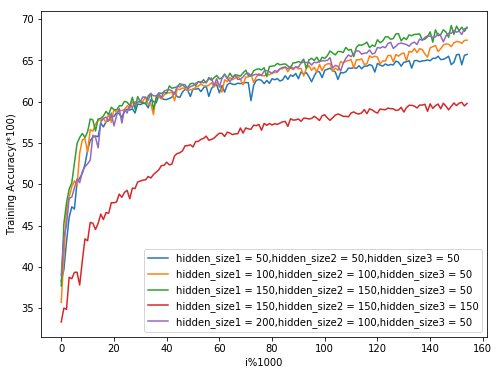

In [115]:
# training acc with different hidden size
plt.figure(figsize = (8,6))
plt.plot(train_acc2,label = 'hidden_size1 = 50,hidden_size2 = 50,hidden_size3 = 50')
plt.plot(train_acc61,label = 'hidden_size1 = 100,hidden_size2 = 100,hidden_size3 = 50')
plt.plot(train_acc31,label = 'hidden_size1 = 150,hidden_size2 = 150,hidden_size3 = 50')
plt.plot(train_acc4,label = 'hidden_size1 = 150,hidden_size2 = 150,hidden_size3 = 150')
plt.plot(train_acc5,label = 'hidden_size1 = 200,hidden_size2 = 100,hidden_size3 = 50')
plt.xlabel("i%1000")
plt.ylabel("Training Accuracy(*100)")
plt.legend(loc = 'best')

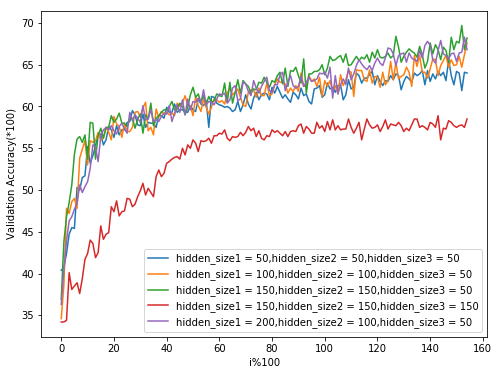

In [60]:
#val acc with different hidden size
plt.figure(figsize = (8,6))
plt.plot(val_acc2,label = 'hidden_size1 = 50,hidden_size2 = 50,hidden_size3 = 50')
plt.plot(val_acc61,label = 'hidden_size1 = 100,hidden_size2 = 100,hidden_size3 = 50')
plt.plot(val_acc31,label = 'hidden_size1 = 150,hidden_size2 = 150,hidden_size3 = 50')
plt.plot(val_acc4,label = 'hidden_size1 = 150,hidden_size2 = 150,hidden_size3 = 150')
plt.plot(val_acc5,label = 'hidden_size1 = 200,hidden_size2 = 100,hidden_size3 = 50')
plt.xlabel("i%100")
plt.ylabel("Validation Accuracy(*100)")
plt.legend(loc = 'best')

# CNN 

In [ ]:
class CNN(nn.Module):
    def __init__(self,k_size,p_size, hidden_size,size2, num_layers, num_classes,emb_size =300):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size, self.size2 = num_layers, hidden_size, size2
        self.k_size,self.p_size = k_size, p_size
        
        self.embedding = nn.Embedding.from_pretrained(Emb_Mtx).float()
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=k_size, padding=p_size)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=k_size, padding=p_size)
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=k_size, padding=p_size)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=k_size, padding=p_size)
        
        self.maxpool1 = nn.MaxPool1d(MAX_SENTENCE_LENGTH)
        self.maxpool2 = nn.MaxPool1d(MAX_SENTENCE_LENGTH)
        
        self.linear1 = nn.Linear(2*hidden_size, size2)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(size2, num_classes)

    def forward(self, x1, lengths1, x2, lengths2):
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()

        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, seq_len1, hidden1.size(-1))
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, seq_len2, hidden2.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, hidden1.size(-1), seq_len1)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, hidden2.size(-1), seq_len2)

        hidden1 = self.maxpool1(hidden1)
        hidden2 = self.maxpool2(hidden2)
        
        # sum hidden activations of CNN across time
        cat_out = torch.cat([hidden1,hidden2],dim = 1) 

        rnn_out = torch.sum(cat_out, dim = -1)
        
        rnn_out = self.linear1(rnn_out)
        rnn_out = self.relu(rnn_out)
        logits = self.linear2(rnn_out)
        
        return logits

# CNN Result

In [ ]:
model = CNN(k_size=5,p_size=2,hidden_size = 200,size2=100, num_layers=2, num_classes=3)
train_loss_a,train_acc_a,val_acc_a =train_model_RNN(model,3e-3,5)

In [ ]:
model = CNN(k_size=2,p_size=3,hidden_size = 200,size2=100, num_layers=2, num_classes=3)
train_loss_b,train_acc_b,val_acc_b =train_model_RNN(model,3e-3,5)

In [ ]:
model = CNN(k_size=2,p_size=3,hidden_size = 100,size2=200, num_layers=2, num_classes=3)
train_loss_c,train_acc_c,val_acc_c =train_model_RNN(model,3e-4,5)

In [ ]:
model = CNN(k_size=2,p_size=5,hidden_size = 50,size2=200, num_layers=5, num_classes=3)
train_loss_d,train_acc_d,val_acc_d =train_model_RNN(model,3e-4,10)

In [ ]:
model = CNN(k_size=3,p_size=2,hidden_size = 150,size2=150, num_layers=5, num_classes=3)
train_loss_e,train_acc_e,val_acc_e =train_model_RNN(model,3e-4,10)